# Line Charts

In [1]:
from adjustText import adjust_text
from cartopy import crs
import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper
import csv
from datetime import datetime
import db_connection as db_con
from descartes import PolygonPatch
import descartes
import folium
from functools import partial
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
import io
from io import StringIO
from matplotlib import cm
from matplotlib.patches import Ellipse, Polygon
import matplotlib.patches as mpatches
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import psycopg2
import psycopg2.extras as extras
from scipy.interpolate import make_interp_spline, BSpline, interp1d
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from sqlalchemy import create_engine, func, distinct
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Colors
colors = ["#3388ff","#A1E2E6", "#E6BDA1", "#B3A16B", "#678072", "#524A4A"]
cmap = cm.get_cmap('viridis', 5)
cmaplist = [cmap(i) for i in range(cmap.N)]

In [3]:
# Import credential and connection settings
db_name = db_con.db_name
db_username = db_con.db_username
db_host = db_con.db_host
db_port = db_con.db_port
db_pwd = db_con.db_pwd
engine_string = f"postgresql://{db_username}:{db_pwd}@{db_host}:{db_port}/{db_name}"
db_engine = create_engine(engine_string)

## Difference in Difference

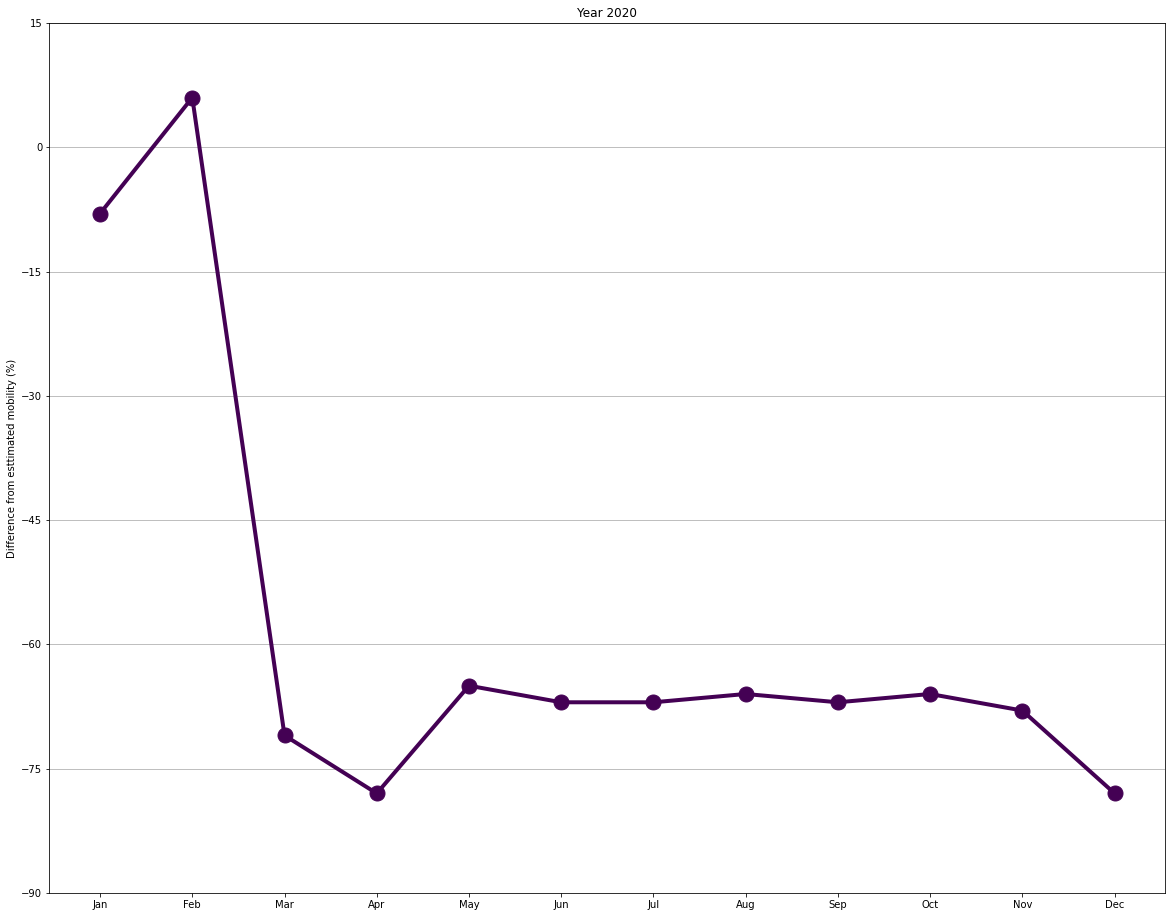

In [4]:
# Diff-in-diff line chart
diff_list = [-8, 6,-71, -78, -65, -67, -67, -66, -67, -66, -68, -78]
fig, ax = plt.subplots(figsize=(20,16))

monthlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.title("Year 2020")
ax.set_ylabel("Difference from esttimated mobility (%)")
ax.set_ylim([-90, 15])
plt.yticks(np.arange(-90, 16, step=15))
plt.grid(b=True, which='major', axis='y', linewidth=1, alpha=0.8) 

ax = plt.plot(monthlabels, diff_list, linewidth=4, marker="o", markersize=15, label='COVID-19', color=cmaplist[0])
plt.show()

## Loading from Database

In [5]:
def load_lines(table_name):
    query = f'SELECT geometry,user_id,dest_country,orig_time,dest_time,duration,post_region,dest_region,region_move,cb_move,distance_km,row_id,country_code FROM {table_name}'
    lines_df = db_con.read_sql_inmem_uncompressed(query, db_engine)
    # Apply wkt
    lines_df['geometry'] = lines_df['geometry'].apply(wkt.loads)
    # Convert to GeoDataFrame
    lines_df_gdf = gpd.GeoDataFrame(lines_df, geometry='geometry')
    # CRS
    lines_df_gdf.crs = "EPSG:4326"
    # Delete dataframe
    del lines_df
    # Convert timestamps
    lines_df_gdf['orig_time'] = lines_df_gdf['orig_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
    lines_df_gdf['dest_time'] = lines_df_gdf['dest_time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d-%H"))
    # Add month
    lines_df_gdf['month'] = lines_df_gdf['dest_time'].apply(lambda x: x.month)
    lines_df_gdf['yearmonth'] = lines_df_gdf['dest_time'].apply(lambda x: int(str(x.year)+str(x.month).zfill(2)))
    # Add day of week
    lines_df_gdf['orig_day_of_week'] = lines_df_gdf['orig_time'].apply(lambda x: x.dayofweek)
    lines_df_gdf['dest_day_of_week'] = lines_df_gdf['dest_time'].apply(lambda x: x.dayofweek)
    print(f"[INFO] - {table_name} loaded")
    return lines_df_gdf


In [6]:
baseline_1 = load_lines("nordic_2017_lines")
baseline_2 = load_lines("nordic_2018_lines")
baseline_3 = load_lines("pre_covid_lines")
covid_lines = load_lines("post_covid_lines")

[INFO] - nordic_2017_lines loaded
[INFO] - nordic_2018_lines loaded
[INFO] - pre_covid_lines loaded
[INFO] - post_covid_lines loaded


In [7]:
def dayAverages(df):
    mondays = 0
    tuesdays = 0
    wednesdays = 0
    thursdays = 0
    fridays = 0
    saturdays = 0
    sundays = 0

    # Iterate over a LineString dataset, calculate average weekdays and variance
    for index, row in df.iterrows():

        # Store weekdays from trip endpoints, convert to timestamps
        day_name_orig = row['orig_day_of_week']
        day_name_dest = row['dest_day_of_week']

        # Count weekdays
        if any( [day_name_orig == 0, day_name_dest == 0] ):
            mondays += 1

        if any( [day_name_orig == 1, day_name_dest == 1] ):
            tuesdays += 1

        if any( [day_name_orig == 2, day_name_dest == 2] ):
            wednesdays += 1

        if any( [day_name_orig == 3, day_name_dest == 3] ):
            thursdays += 1

        if any( [day_name_orig == 4, day_name_dest == 4] ):
            fridays += 1

        if any( [day_name_orig == 5, day_name_dest == 5] ):
            saturdays += 1

        if any( [day_name_orig == 6, day_name_dest == 6] ):
            sundays += 1

    avg = (mondays + tuesdays + wednesdays + thursdays + fridays + saturdays + sundays) / 7
    averages = {'average': avg, 'mondays': mondays, 'tuesdays': tuesdays, 'wednesdays': wednesdays, 'thursdays': thursdays, 'fridays': fridays, 'saturdays': saturdays, 'sundays': sundays}
    diffs = [((mondays/avg)*100)-100,((tuesdays/avg)*100)-100,((wednesdays/avg)*100)-100,((thursdays/avg)*100)-100,((fridays/avg)*100)-100,((saturdays/avg)*100)-100,((sundays/avg)*100)-100]
    days = [mondays,tuesdays,wednesdays,thursdays,fridays,saturdays,sundays]
    return averages, diffs, days

### Weighting

In [8]:
def w_avg(input_values, w):
    weighted = np.average(input_values,weights=w)
    return weighted
w1 = np.array([1,0.986,1.150])

In [9]:
def weighted_average_days(input_1,input_2,input_3, w):
    days_bl1 = np.array(dayAverages(input_1)[2])
    days_bl2 = np.array(dayAverages(input_2)[2])
    days_bl3 = np.array(dayAverages(input_3)[2])
    weighted_days = []
    for i in range(len(days_bl1)):
        day_vals = np.array([days_bl1[i], days_bl2[i], days_bl3[i]])
        weighted_days.append(int(round( w_avg(day_vals,w1),0 )))
    weighted_avg = sum(weighted_days)/7
    weighted_diffs = [((weighted_days[0]/weighted_avg)*100)-100,((weighted_days[1]/weighted_avg)*100)-100,((weighted_days[2]/weighted_avg)*100)-100,((weighted_days[3]/weighted_avg)*100)-100,((weighted_days[4]/weighted_avg)*100)-100,((weighted_days[5]/weighted_avg)*100)-100,((weighted_days[6]/weighted_avg)*100)-100]
    return weighted_diffs, weighted_days

In [10]:
days_bl1 = np.array(dayAverages(baseline_1)[2])
days_bl2 = np.array(dayAverages(baseline_2)[2])
days_bl3 = np.array(dayAverages(baseline_3)[2])

In [11]:
weighted_days = []
for i in range(len(days_bl1)):
    day_vals = np.array([days_bl1[i], days_bl2[i], days_bl3[i]])
    weighted_days.append(int(round( w_avg(day_vals,w1),0 )))

In [12]:
weighted_avg = sum(weighted_days)/7
weighted_diffs = [((weighted_days[0]/weighted_avg)*100)-100,((weighted_days[1]/weighted_avg)*100)-100,((weighted_days[2]/weighted_avg)*100)-100,((weighted_days[3]/weighted_avg)*100)-100,((weighted_days[4]/weighted_avg)*100)-100,((weighted_days[5]/weighted_avg)*100)-100,((weighted_days[6]/weighted_avg)*100)-100]
print(f"Weighted days: {weighted_days}")
print(f"Weighted diffs: {weighted_diffs}")
print(f"COVID days: {dayAverages(covid_lines)[2]}")
print(f"COVID diffs: {dayAverages(covid_lines)[1]}")

Weighted days: [12416, 12971, 13413, 13902, 13831, 12693, 12137]
Weighted diffs: [-4.8717752262950995, -0.6195068025349428, 2.766984446657844, 6.5135777065113984, 5.969593818066386, -2.749471886868875, -7.009402055536711]
COVID days: [2630, 2562, 2707, 2729, 2776, 2687, 2669]
COVID diffs: [-1.8656716417910388, -4.402985074626869, 1.0074626865671803, 1.8283582089552226, 3.5820895522387985, 0.261194029850742, -0.41044776119403537]


## Weekday Line Chart

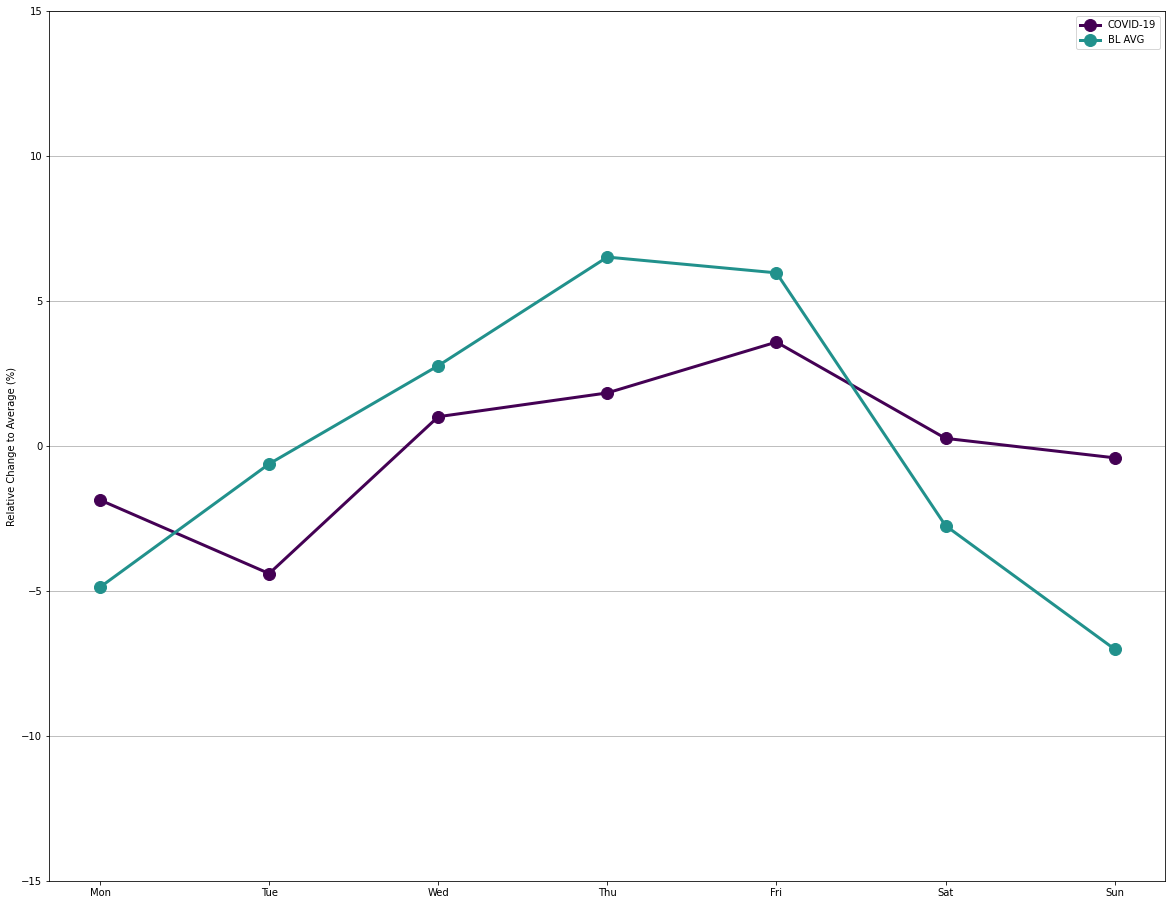

In [13]:
fig, ax = plt.subplots(figsize=(20,16))
weekdays = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
ax.set_ylabel("Relative Change to Average (%)")
ax.set_ylim([-15, 15])
plt.yticks(np.arange(-15, 16, step=5))
plt.rcParams["legend.loc"] = 'upper right'

ax = plt.plot(weekdays, dayAverages(covid_lines)[1], linewidth=3, marker="o", markersize=12, label='COVID-19', color=cmaplist[0])
ax = plt.plot(weekdays, weighted_diffs, linewidth=3, marker="o", markersize=12, label='BL AVG', color=cmaplist[2])
plt.grid(b=True, which='major', axis='y', linewidth=1, alpha=0.8)
plt.legend()

plt.show()

## Monthly data

In [14]:
def monthAverages(df):
    avg = len(df)/12
    diffs = (((df['month'].value_counts()/avg)*100)-100).sort_index()
    diffs_order = diffs[2:].append(diffs[:2])
    return diffs_order

In [15]:
def weighted_average_months(input_1,input_2,input_3, w):
    months_bl1 = np.array(monthAverages(input_1))
    months_bl2 = np.array(monthAverages(input_2))
    months_bl3 = np.array(monthAverages(input_3))
    weighted_months = []
    for i in range(len(months_bl1)):
        month_vals = np.array([months_bl1[i], months_bl2[i], months_bl3[i]])
        weighted_months.append(int(round( w_avg(month_vals,w1),2 )))
    return weighted_months

In [16]:
months_bl1 = np.array(monthAverages(baseline_1))
months_bl2 = np.array(monthAverages(baseline_2))
months_bl3 = np.array(monthAverages(baseline_3))

In [17]:
weighted_months = []

for i in range(len(months_bl1)):
    month_vals = np.array([months_bl1[i], months_bl2[i], months_bl3[i]])
    weighted_months.append(int(round( w_avg(month_vals,w1),2 )))

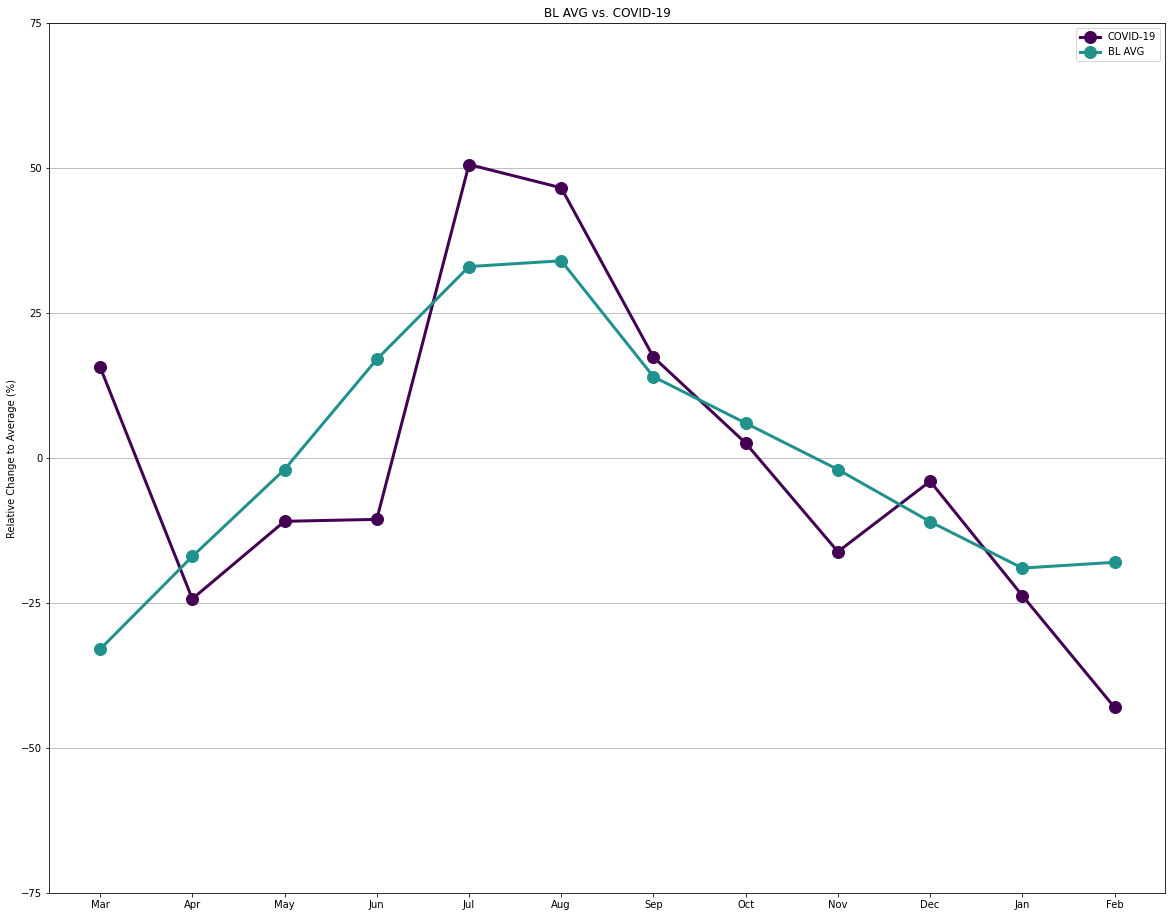

In [18]:
fig, ax = plt.subplots(figsize=(20,16))
plt.title("BL AVG vs. COVID-19")
monthlabels = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']
ax.set_ylabel("Relative Change to Average (%)")
ax.set_ylim([-75, 75])
plt.yticks(np.arange(-75, 76, step=25))

ax = plt.plot(monthlabels, monthAverages(covid_lines), linewidth=3, marker="o", markersize=12, label='COVID-19', color=cmaplist[0])
ax = plt.plot(monthlabels, weighted_months, linewidth=3, marker="o", markersize=12, label='BL AVG', color=cmaplist[2])
plt.grid(b=True, which='major', axis='y', linewidth=1, alpha=0.8)
plt.legend()
plt.show()

## Country Comparison - Monthly

In [19]:
def country_pair_months(country_one,country_two, baseline_1,baseline_2,baseline_3,covid_lines):
    countries_string = f"{country_one}-{country_two}|{country_two}-{country_one}"
    baseline_1 = baseline_1[baseline_1['cb_move'].str.match(countries_string)]
    baseline_2 = baseline_2[baseline_2['cb_move'].str.match(countries_string)]
    baseline_3 = baseline_3[baseline_3['cb_move'].str.match(countries_string)]
    baseline_weighted = weighted_average_months(baseline_1,baseline_2,baseline_3, w1)
    covid_lines = covid_lines[covid_lines['cb_move'].str.match(countries_string)]
    # Plot
    fig, ax = plt.subplots(figsize=(22,16))
    title_string = f"{country_one}--{country_two}"
    plt.title(title_string)
    monthlabels = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']
    ax.set_ylabel("Relative Change to Average (%)")
    ax.set_ylim([-75, 175])
    plt.yticks(np.arange(-75, 176, step=25))
    x = np.arange(len(monthlabels))
    ax.set_xticks(x)
    ax.set_xticklabels(monthlabels)
    plt.rcParams["legend.loc"] = 'upper right'
    # Non-smoothing
    ax = plt.plot(monthlabels, monthAverages(covid_lines), marker="o", markersize=12, label='COVID-19', color=cmaplist[0])
    ax = plt.plot(monthlabels, baseline_weighted, marker="o", markersize=12, label='BL AVG', color=cmaplist[2])
    plt.grid(b=True, which='major', axis='y', linewidth=1, alpha=0.8)

    plt.legend()
    file_string = f"{country_one}-{country_two}-months_lines.JPEG"
    plt.show()
    plt.close()
    print(f"[INFO] - {title_string} created")

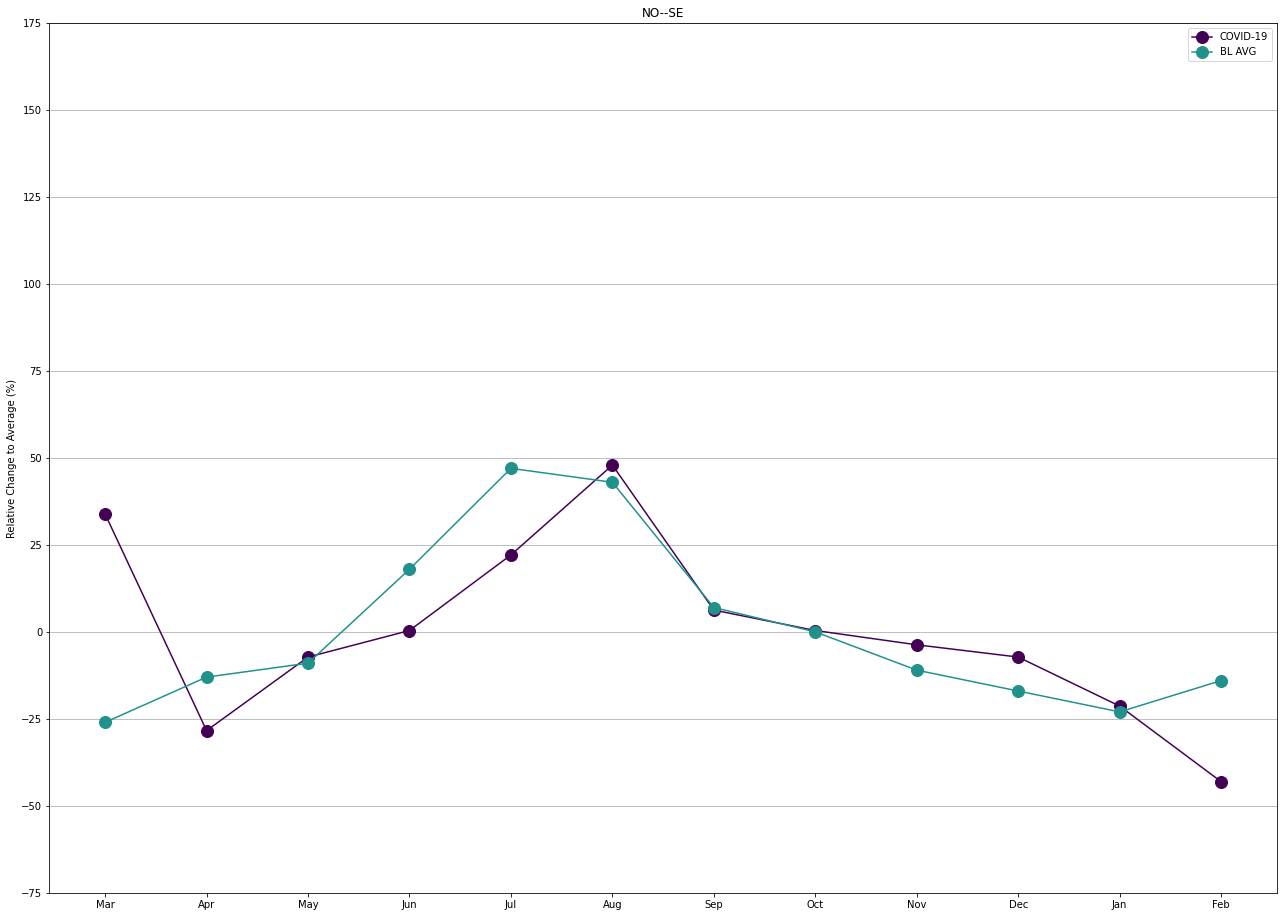

[INFO] - NO--SE created


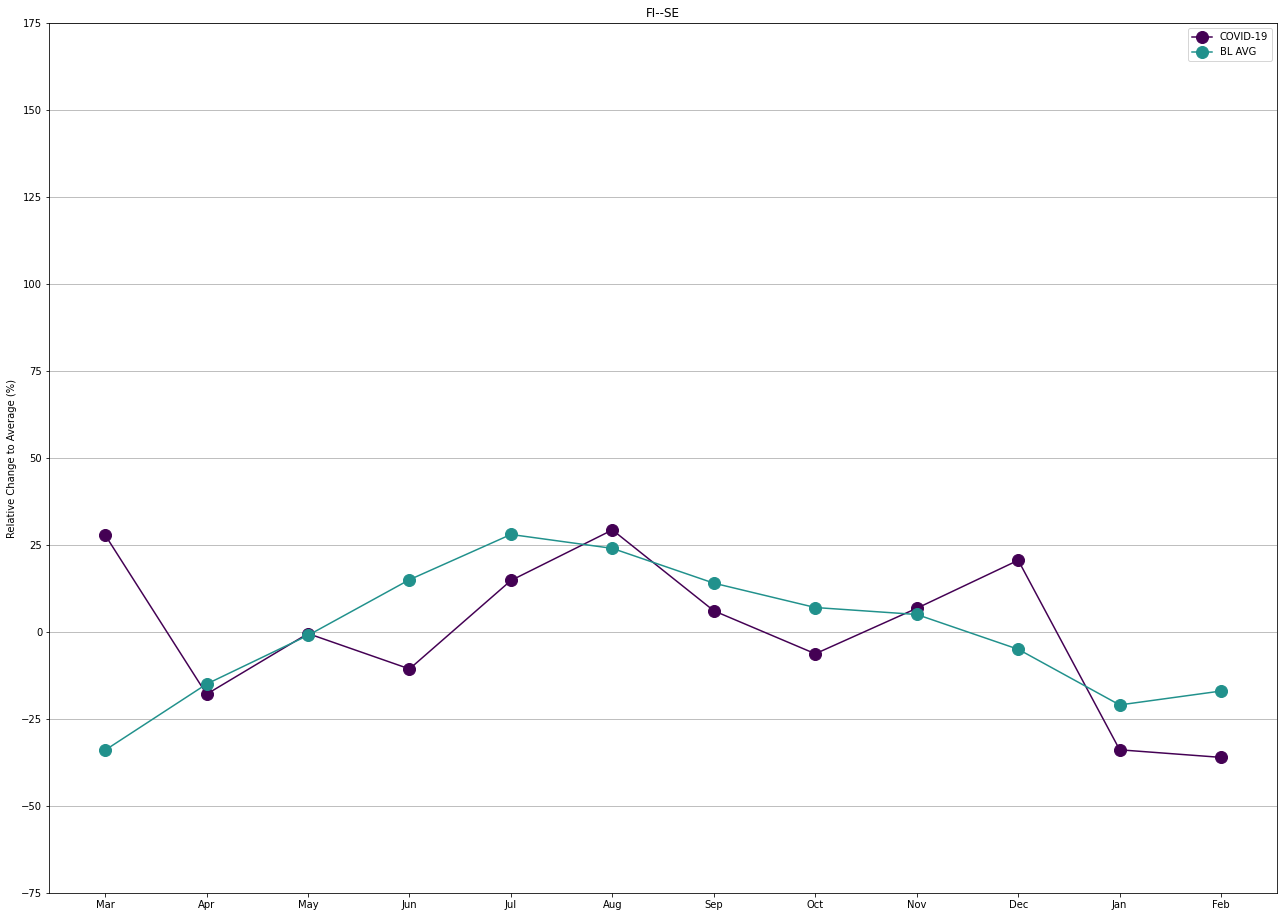

[INFO] - FI--SE created


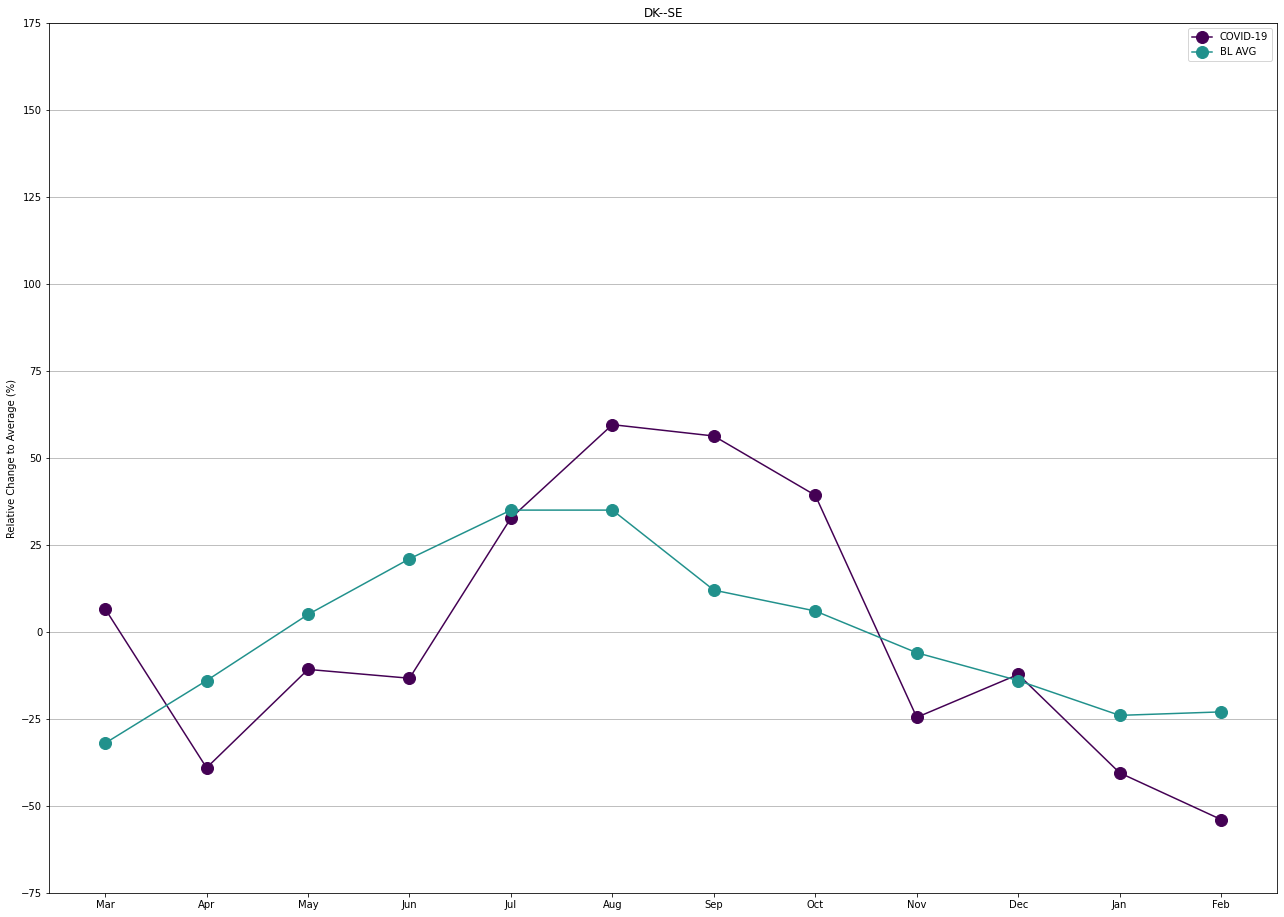

[INFO] - DK--SE created


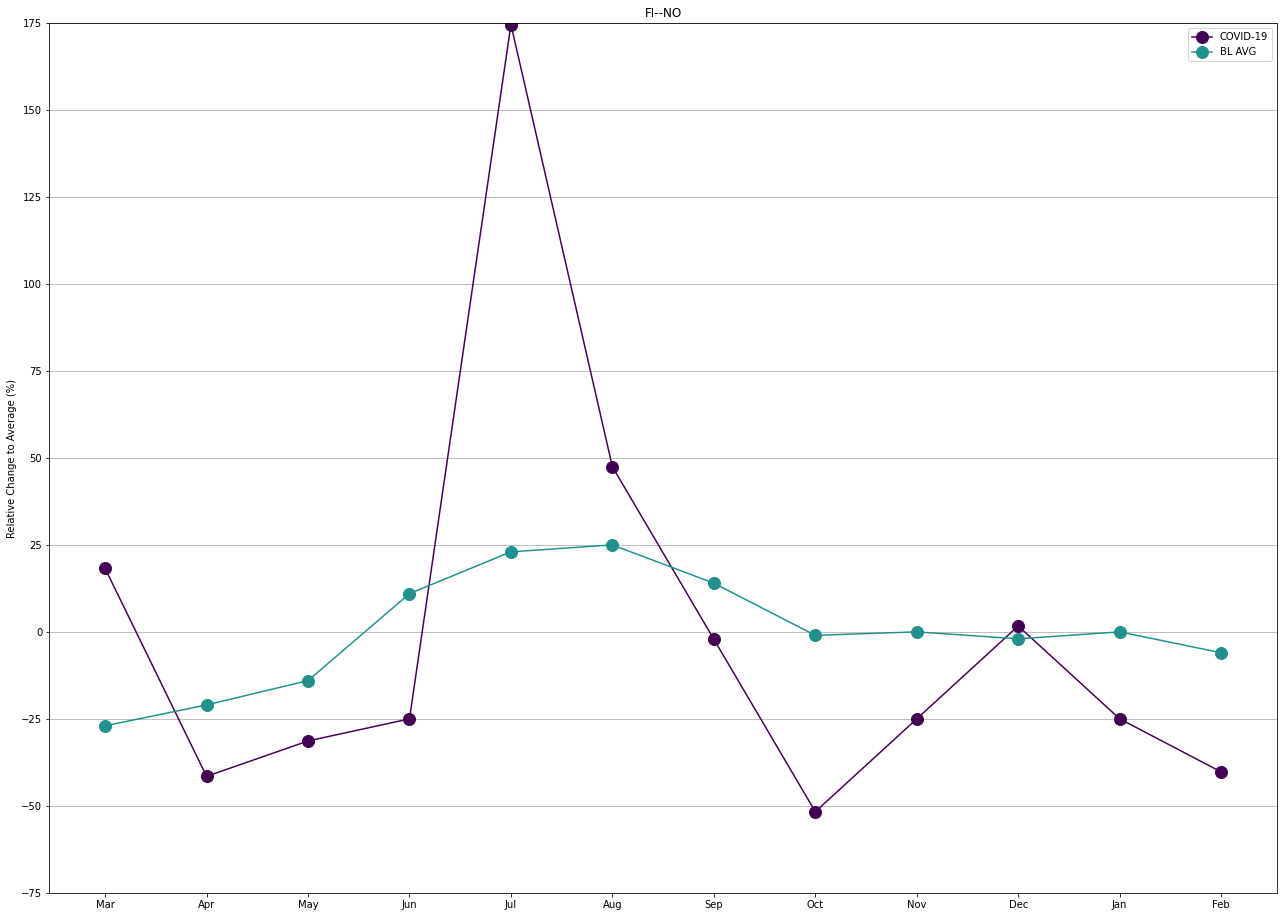

[INFO] - FI--NO created


In [20]:
country_pair_months('NO','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_months('FI','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_months('DK','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_months('FI','NO', baseline_1,baseline_2,baseline_3,covid_lines)

## Country comparison - Weekly

In [21]:
def country_pair_weekdays(country_one,country_two, baseline_1,baseline_2,baseline_3,covid_lines):
    countries_string = f"{country_one}-{country_two}|{country_two}-{country_one}"
    baseline_1 = baseline_1[baseline_1['cb_move'].str.match(countries_string)]
    baseline_2 = baseline_2[baseline_2['cb_move'].str.match(countries_string)]
    baseline_3 = baseline_3[baseline_3['cb_move'].str.match(countries_string)]
    baseline_weighted = weighted_average_days(baseline_1,baseline_2,baseline_3, w1)
    covid_lines = covid_lines[covid_lines['cb_move'].str.match(countries_string)]
    # plot
    fig, ax = plt.subplots(figsize=(20,16))
    title_string = f"{country_one}--{country_two}"
    plt.title(title_string)
    weekdays = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
    ax.set_ylabel("Relative Change to Average (%)")
    ax.set_ylim([-25, 26])
    plt.yticks(np.arange(-25, 26, step=5))
    plt.rcParams["legend.loc"] = 'upper right'

    ax = plt.plot(weekdays, dayAverages(covid_lines)[1], linewidth=3, marker="o", markersize=12, label='COVID-19', color=cmaplist[0])
    ax = plt.plot(weekdays, baseline_weighted[0], linewidth=3, marker="o", markersize=12, label='BL AVG', color=cmaplist[2])
    plt.grid(b=True, which='major', axis='y', linewidth=1, alpha=0.8)

    plt.legend()
    file_string = f"{country_one}-{country_two}-weekdays_lines.JPEG"
    plt.show()
    plt.close()
    print(f"[INFO] - {title_string} created")

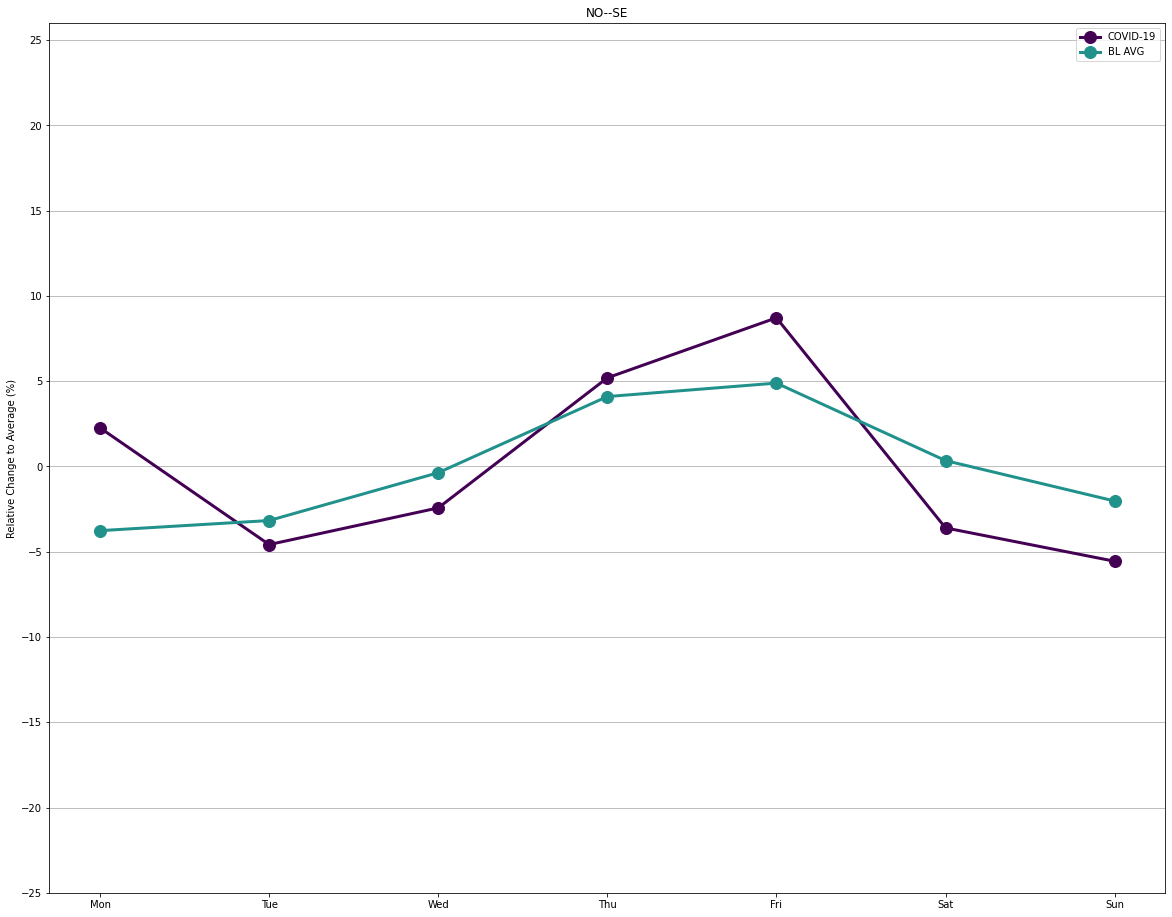

[INFO] - NO--SE created


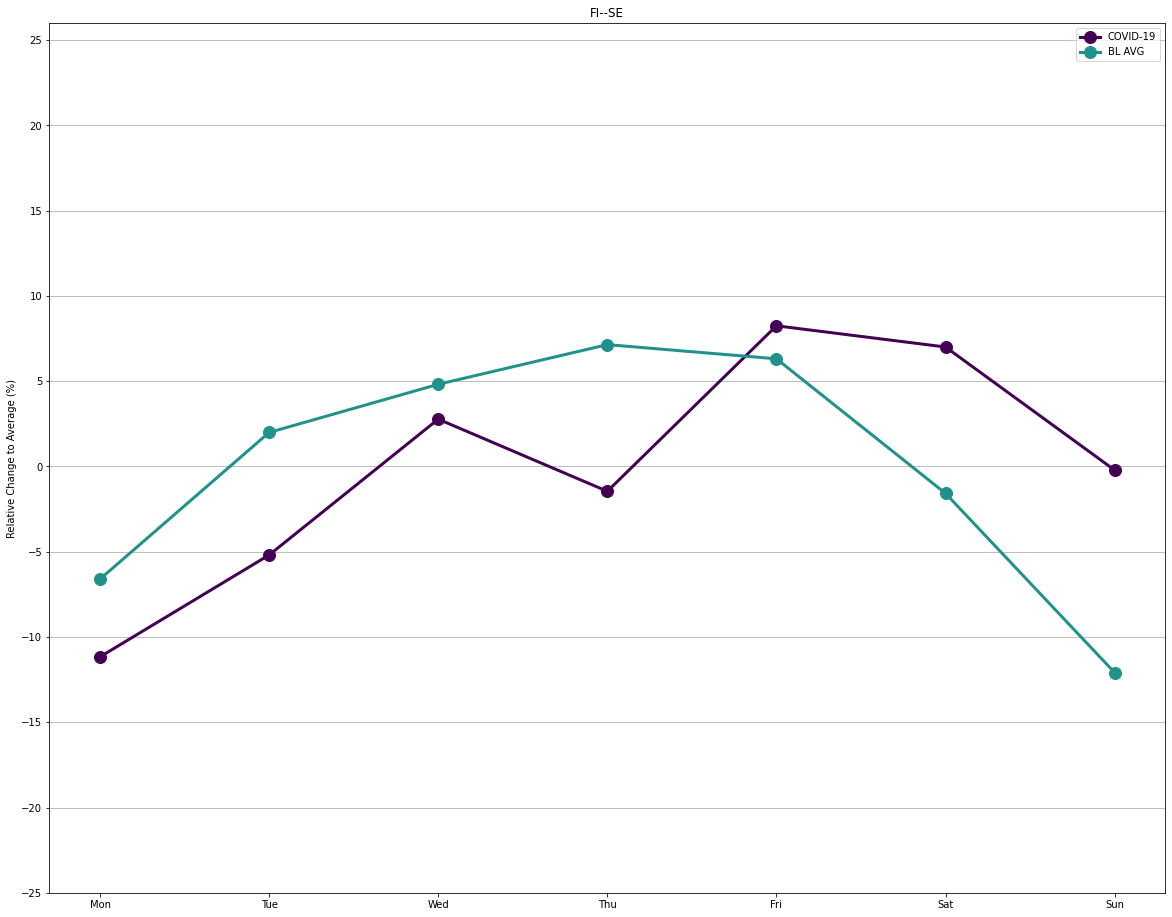

[INFO] - FI--SE created


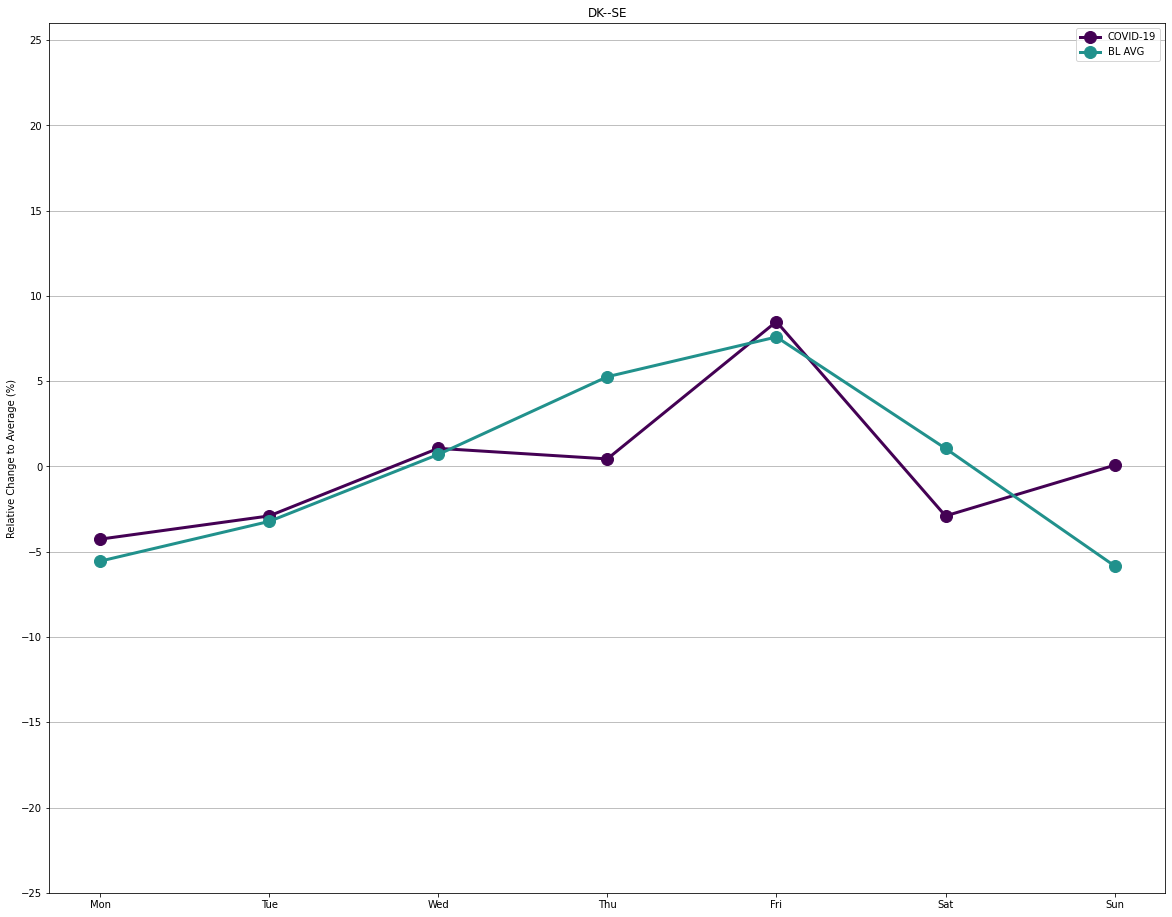

[INFO] - DK--SE created


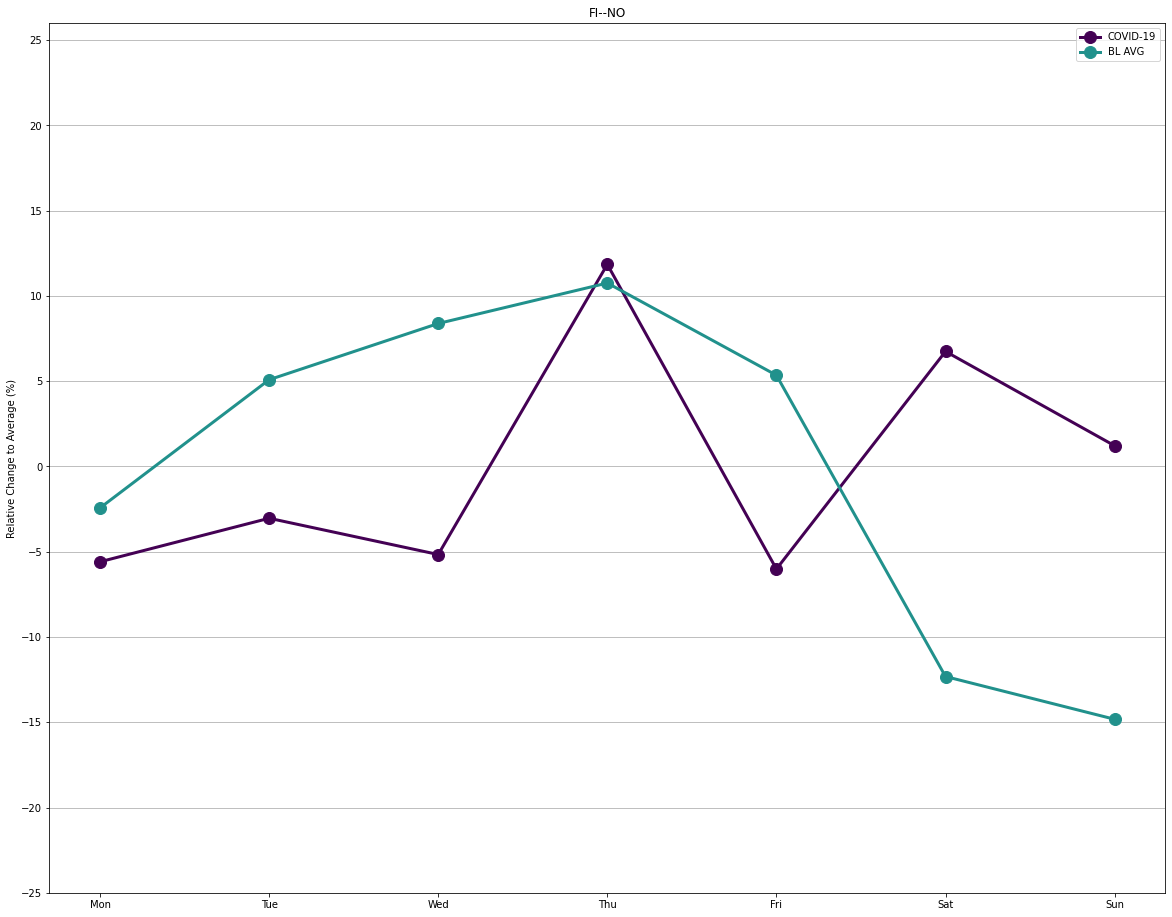

[INFO] - FI--NO created


In [22]:
country_pair_weekdays('NO','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_weekdays('FI','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_weekdays('DK','SE', baseline_1,baseline_2,baseline_3,covid_lines)
country_pair_weekdays('FI','NO', baseline_1,baseline_2,baseline_3,covid_lines)